In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [47]:
df_sentiment = pd.read_csv("fear_greed_index.csv")
df_trader = pd.read_csv("historical_data.csv")


In [48]:
df_trader['Timestamp'] = pd.to_datetime(df_trader['Timestamp'], unit='ms')
df_trader['Date'] = df_trader['Timestamp'].dt.strftime('%Y-%m-%d')


In [49]:
df_sentiment['date'] = pd.to_datetime(df_sentiment['date'])
df_sentiment['Date'] = df_sentiment['date'].dt.strftime('%Y-%m-%d')


In [50]:
df_trader.rename(columns={
    'Account': 'account',
    'Closed PnL': 'closedPnL',
    'Size USD': 'sizeUSD',
    'Fee': 'fee'
}, inplace=True)


In [51]:
df = df_trader.merge(
    df_sentiment[['Date','classification']],
    on='Date',
    how='left'
)

df['classification'] = df['classification'].ffill()


In [52]:
daily_pnl = df.groupby(['account','Date'])['closedPnL'].sum().reset_index()
daily_pnl.rename(columns={'closedPnL':'dailyPnL'}, inplace=True)


In [53]:
df['win'] = (df['closedPnL'] > 0).astype(int)

win_rate = df.groupby(['account','Date'])['win'].mean().reset_index()
win_rate.rename(columns={'win':'winRate'}, inplace=True)


In [54]:
trade_freq = df.groupby(['account','Date']).size().reset_index(name='numTrades')


In [55]:
trade_size = df.groupby(['account','Date'])['sizeUSD'].mean().reset_index()


In [56]:
fees = df.groupby(['account','Date'])['fee'].sum().reset_index()


In [57]:
metrics = daily_pnl.merge(win_rate, on=['account','Date'])
metrics = metrics.merge(trade_freq, on=['account','Date'])
metrics = metrics.merge(trade_size, on=['account','Date'])
metrics = metrics.merge(fees, on=['account','Date'])

metrics = metrics.merge(df_sentiment[['Date','classification']], on='Date', how='left')


In [58]:
plot_data = metrics.dropna()


In [59]:
metrics.groupby('classification')['dailyPnL'].mean()
metrics.groupby('classification')['winRate'].mean()


classification
Extreme Greed    0.336609
Fear             0.415878
Greed            0.374074
Neutral          0.260683
Name: winRate, dtype: float64

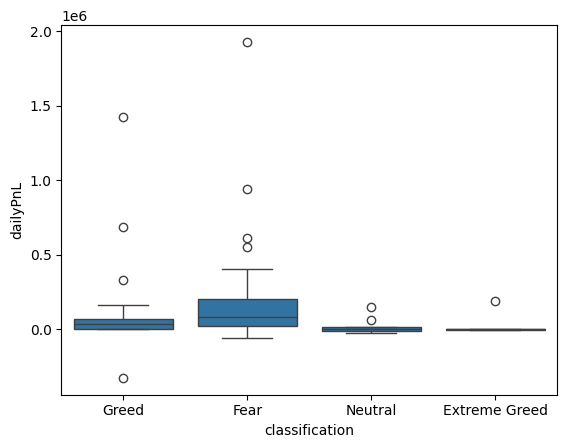

In [60]:
sns.boxplot(data=plot_data, x='classification', y='dailyPnL')
plt.show()


In [61]:
metrics.groupby('classification')[['numTrades','sizeUSD','fee']].mean()


,numTrades,sizeUSD,fee
classification,,,
Extreme Greed,1392.40000,4344.447836,1362.556247
Fear,4183.46875,5926.522723,4531.813863
Greed,1134.03125,5839.310974,760.438543
Neutral,892.62500,3793.444161,1092.984686


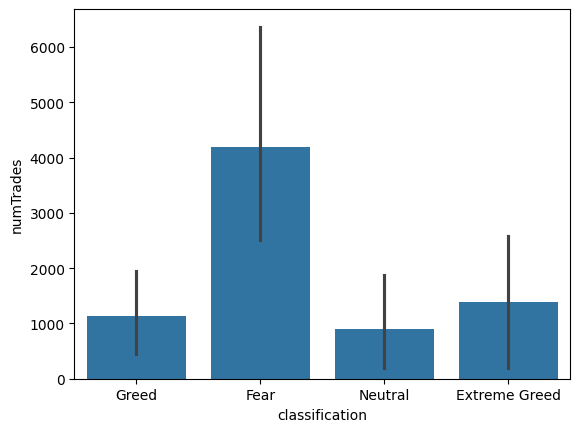

In [62]:
sns.barplot(data=plot_data, x='classification', y='numTrades')
plt.show()


In [63]:
#Segmentation
threshold = metrics['numTrades'].median()

metrics['traderType'] = np.where(metrics['numTrades'] > threshold,
                                 'Frequent','Infrequent')


In [65]:
#Winners vs Losers
overall = metrics.groupby('account')['dailyPnL'].mean().reset_index()

threshold = overall['dailyPnL'].median()

overall['performanceType'] = np.where(overall['dailyPnL'] > threshold,
                                      'Winners','Losers')

metrics = metrics.merge(overall[['account','performanceType']], on='account')


In [67]:
overall = metrics.groupby('account')['dailyPnL'].mean().reset_index()

threshold = overall['dailyPnL'].median()

overall['performanceType'] = np.where(
    overall['dailyPnL'] > threshold,
    'Winners',
    'Losers'
)

metrics = metrics.merge(overall[['account','performanceType']], on='account')


In [68]:
metrics.groupby(['classification','traderType'])['dailyPnL'].mean()
metrics.groupby(['classification','performanceType'])['numTrades'].mean()


classification  performanceType
Extreme Greed   Losers               27.0000
                Winners            1733.7500
Fear            Losers             2545.8125
                Winners            5821.1250
Greed           Losers              709.2500
                Winners            1558.8125
Neutral         Losers              983.5000
                Winners             801.7500
Name: numTrades, dtype: float64

In [69]:
metrics.head()
metrics.describe()
metrics.isnull().sum()

account               0
Date                  0
dailyPnL              0
winRate               0
numTrades             0
sizeUSD               0
fee                   0
classification       25
traderType            0
performanceType_x     0
performanceType_y     0
performanceType       0
dtype: int64

In [71]:
metrics.groupby('classification')['dailyPnL'].mean()



classification
Extreme Greed     35393.098355
Fear             209372.662205
Greed             99675.516731
Neutral           19842.797260
Name: dailyPnL, dtype: float64

In [72]:
metrics.groupby('classification')['winRate'].mean()


classification
Extreme Greed    0.336609
Fear             0.415878
Greed            0.374074
Neutral          0.260683
Name: winRate, dtype: float64

In [73]:
metrics.groupby('classification')[['numTrades','sizeUSD','fee']].mean()


,numTrades,sizeUSD,fee
classification,,,
Extreme Greed,1392.40000,4344.447836,1362.556247
Fear,4183.46875,5926.522723,4531.813863
Greed,1134.03125,5839.310974,760.438543
Neutral,892.62500,3793.444161,1092.984686


Insights Summary:-

Fear regimes exhibit the highest trader win rates, suggesting improved decision accuracy under stressed market conditions.

1.Traders demonstrate increased activity and larger position sizes during Fear periods, indicating opportunistic behavior despite negative sentiment.
2.Performance deteriorates during Extreme Greed phases, consistent with potential overconfidence effects.
3.Neutral regimes show the lowest trading engagement, implying traders favor sentiment-driven environments.

Strategy Recommendations:-

1.Leverage Fear regimes by selectively increasing trading participation while maintaining disciplined risk management.
2.Apply tighter leverage and position size controls during Extreme Greed periods to reduce behavioral risk.